#IS 470 Lab 11: Recommender systems and social network analysis

---
In this lab, we will first build recommender systems based on movie rating data. 
We then perform social network analysis based on a small Facebook data.

## Part 1: Recommender Systems<br>
We will use the MovieLense data set (downloaded from http://www.grouplens.org/), which contains around 100,000 ratings (1-5) from 943 users on 1682 movies.<br> 
<br>
In this MovieLense data set, each row corresponds to a user, and each column corresponds to a movie.<br>
<br>

###1. Upload and clean data

In [1]:
# Upload data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving u.data to u.data
Saving u.item to u.item
Saving u.user to u.user
User uploaded file "u.data" with length 1979173 bytes
User uploaded file "u.item" with length 236344 bytes
User uploaded file "u.user" with length 22628 bytes


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
# Read user data
u_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_columns)
users

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [4]:
# Read movie data
m_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('u.item', sep='|', names=m_columns, usecols=range(5), encoding='latin-1')
movies

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


In [5]:
# Read rating data
r_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep = '\t', names=r_columns)
ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [6]:
# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
MovieLense = pd.merge(movie_ratings, users)
MovieLense

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,timestamp,age,gender,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,748,"Saint, The (1997)",14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Saint%2C%20Th...,729,4,893286638,19,M,student,56567
99996,751,Tomorrow Never Dies (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,729,3,893286338,19,M,student,56567
99997,879,"Peacemaker, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Peacemaker%2C...,729,3,893286299,19,M,student,56567
99998,894,Home Alone 3 (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,729,1,893286511,19,M,student,56567


In [7]:
# Show the head of data frame
MovieLense.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,timestamp,age,gender,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


###2. Explore the MovieLense data

In [8]:
# Rating information
MovieLense['rating'].mean()

3.52986

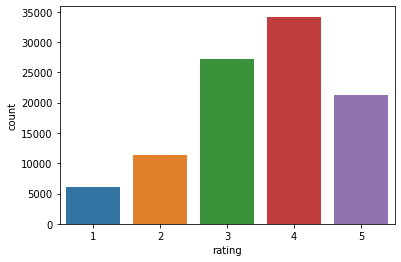

In [9]:
# Rating distribution
sns.countplot(x='rating', data=MovieLense)

In [10]:
# Partition the data
target = MovieLense['rating']
predictors = MovieLense[['user_id', 'movie_id', 'rating']]
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.3, random_state=0)
print(predictors_train.shape, predictors_test.shape, target_train.shape, target_test.shape)

(70000, 3) (30000, 3) (70000,) (30000,)


In [11]:
# Create user-item matrix for training and testing data
train_matrix = np.zeros([len(users), len(movies)])
for line in predictors_train.itertuples():
  train_matrix[line.user_id-1, line.movie_id-1] = line.rating

test_matrix = np.zeros([len(users), len(movies)])
for line in predictors_test.itertuples():
  test_matrix[line.user_id-1, line.movie_id-1] = line.rating

### 3. Recommender systems

In [12]:
# calculate the average rating for each user
average_user_rating = np.true_divide(train_matrix.sum(1),(train_matrix!=0).sum(1))

# create a train_matrix_sp represents users' preferences on different movies
train_matrix_sp = csr_matrix(train_matrix, dtype=np.float64)
nz = train_matrix_sp.nonzero()
train_matrix_sp[nz] -= average_user_rating[nz[0]]
train_matrix_sp = train_matrix_sp.toarray()

# calculate the user and movie similarity
user_similarity = pairwise_distances(train_matrix_sp)
movie_similarity = pairwise_distances(train_matrix_sp.T)
np.fill_diagonal(user_similarity, 0)
np.fill_diagonal(movie_similarity, 0)
print(user_similarity)
print(movie_similarity)

[[ 0.         19.36746322 20.03224615 ... 18.63662597 19.15733365
  22.54074153]
 [19.36746322  0.         10.20873295 ...  7.72607971  8.41923208
  15.30622059]
 [20.03224615 10.20873295  0.         ...  8.41003834  9.44275871
  15.87081459]
 ...
 [18.63662597  7.72607971  8.41003834 ...  0.          6.88033657
  14.34856006]
 [19.15733365  8.41923208  9.44275871 ...  6.88033657  0.
  14.9490956 ]
 [22.54074153 15.30622059 15.87081459 ... 14.34856006 14.9490956
   0.        ]]
[[ 0.         19.1737482  18.90788176 ... 16.45684966 16.41712735
  16.43402975]
 [19.1737482   0.         12.55036183 ...  9.2058676   9.13466847
   9.1407323 ]
 [18.90788176 12.55036183  0.         ...  8.94331869  8.87001234
   8.87625697]
 ...
 [16.45684966  9.2058676   8.94331869 ...  0.          1.14298498
   1.19047619]
 [16.41712735  9.13466847  8.87001234 ...  1.14298498  0.
   0.33377135]
 [16.43402975  9.1407323   8.87625697 ...  1.19047619  0.33377135
   0.        ]]


In [13]:
# Create a collaborative filtering algorithm
zero_index = np.zeros(train_matrix_sp.shape)
zero_index[nz] = 1
def collaborative_filtering (type = 'user'):
  if type == 'user':
    pre_rating = average_user_rating[:, np.newaxis] + np.dot(user_similarity, train_matrix_sp)/np.dot(user_similarity, zero_index)
  if type == 'item':
    pre_rating = (np.dot(movie_similarity, train_matrix.T)/np.dot(movie_similarity, zero_index.T)).T
  return pre_rating


In [14]:
# make predictions
user_prediction = collaborative_filtering(type='user')
item_prediction = collaborative_filtering(type='item')
user_prediction = np.nan_to_num(user_prediction, nan=4)
item_prediction = np.nan_to_num(item_prediction, nan=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [15]:
# Examine the evaluation results of user-based collaborative filtering on testing data: MAE and RMSE
MAE = mean_absolute_error(test_matrix[test_matrix!=0], user_prediction[test_matrix!=0])
RMSE = mean_squared_error(test_matrix[test_matrix!=0], user_prediction[test_matrix!=0], squared=False)
print("MAE:", MAE)
print("RMSE:", RMSE)

MAE: 0.7585179218197365
RMSE: 0.9645246104251158


In [16]:
# Examine the evaluation results of item-based collaborative filtering on testing data: MAE and RMSE
MAE = mean_absolute_error(test_matrix[test_matrix!=0], item_prediction[test_matrix!=0])
RMSE = mean_squared_error(test_matrix[test_matrix!=0], item_prediction[test_matrix!=0], squared=False)
print("MAE:", MAE)
print("RMSE:", RMSE)

MAE: 0.8380979071269535
RMSE: 1.0492313112201652


Q1. Which recommender system has better performance, user-based or item-based, and why? <br>
The user-based collaborative filtering provides better performance. This is because it has a lower MAE and RMSE value.<br> MAE: 0.7585179218197365<br>
RMSE: 0.9645246104251158


## Part 2: Social Network Analysis<br>
We will use a small Facebook data from stanford network analysis project: https://snap.stanford.edu/data/ego-Facebook.html.<br> 
<br>
The social network is stored by an edgelist.<br>
<br>

###1. Upload and clean data

In [17]:
# Upload data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving facebook_edges.txt to facebook_edges.txt
User uploaded file "facebook_edges.txt" with length 2754 bytes


In [18]:
# Import packages
import networkx as nx
import seaborn as sns

In [19]:
# Read data
G = nx.read_edgelist("facebook_edges.txt")

###2. Social Network Analysis

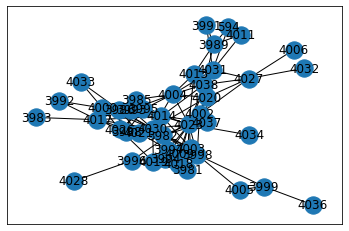

In [20]:
# Visualize the network (every time you run this line of code, the network will be different)
nx.draw_networkx(G)

In [21]:
# Number of nodes
G.number_of_nodes()

44

In [22]:
# Number of edges
G.number_of_edges()

138

In [23]:
# Network density
nx.density(G)

0.14587737843551796

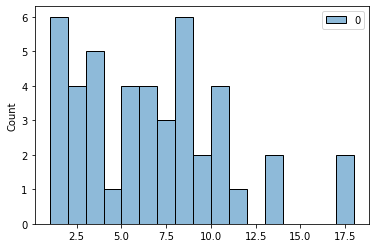

In [26]:
# Degree centrality
nx.degree(G)
sns.histplot(dict(nx.degree(G)).values(), binwidth=1)

In [27]:
# Betweenness centrality
nx.betweenness_centrality(G, normalized=False)

{'3981': 1.5049486461251167,
 '3982': 46.745153294418,
 '3983': 0.0,
 '3985': 2.3395604395604392,
 '3986': 26.655232675820912,
 '3988': 4.9829365079365076,
 '3989': 7.251298701298701,
 '3991': 0.492929292929293,
 '3992': 0.0,
 '3993': 2.2737484737484737,
 '3994': 52.30431594549242,
 '3995': 25.340260393201568,
 '3996': 42.833333333333336,
 '3997': 7.815889094565562,
 '3998': 146.52607792534263,
 '3999': 42.0,
 '4000': 34.485481185481184,
 '4002': 70.55945165945167,
 '4003': 0.0,
 '4004': 48.33808658661602,
 '4005': 0.0,
 '4006': 0.0,
 '4009': 6.8462351374116075,
 '4011': 0.492929292929293,
 '4013': 10.042606739665564,
 '4014': 86.2458352105411,
 '4017': 64.78486970545795,
 '4018': 1.6815947940947942,
 '4019': 6.257597957597956,
 '4020': 55.92873319490966,
 '4021': 29.40607905166728,
 '4023': 202.9092994423877,
 '4026': 7.826003163503165,
 '4027': 83.9429292929293,
 '4028': 0.0,
 '4030': 172.320820192879,
 '4031': 128.29830447330448,
 '4032': 0.0,
 '4033': 0.0,
 '4034': 0.0,
 '4036': 0.

In [28]:
# Closeness centrality
nx.closeness_centrality(G)

{'3981': 0.41346153846153844,
 '3982': 0.5,
 '3983': 0.2986111111111111,
 '3985': 0.38738738738738737,
 '3986': 0.4215686274509804,
 '3988': 0.3944954128440367,
 '3989': 0.33858267716535434,
 '3991': 0.3208955223880597,
 '3992': 0.3049645390070922,
 '3993': 0.39814814814814814,
 '3994': 0.4777777777777778,
 '3995': 0.45263157894736844,
 '3996': 0.36752136752136755,
 '3997': 0.4725274725274725,
 '3998': 0.5119047619047619,
 '3999': 0.34959349593495936,
 '4000': 0.4095238095238095,
 '4002': 0.45263157894736844,
 '4003': 0.4215686274509804,
 '4004': 0.48314606741573035,
 '4005': 0.3467741935483871,
 '4006': 0.2847682119205298,
 '4009': 0.4673913043478261,
 '4011': 0.3233082706766917,
 '4013': 0.41346153846153844,
 '4014': 0.5119047619047619,
 '4017': 0.4215686274509804,
 '4018': 0.4479166666666667,
 '4019': 0.4174757281553398,
 '4020': 0.48314606741573035,
 '4021': 0.45263157894736844,
 '4023': 0.5657894736842105,
 '4026': 0.4174757281553398,
 '4027': 0.3944954128440367,
 '4028': 0.270440

In [29]:
# Transitivity
nx.transitivity(G)

0.44404332129963897

4023
4018
3997
3998
3994
3981


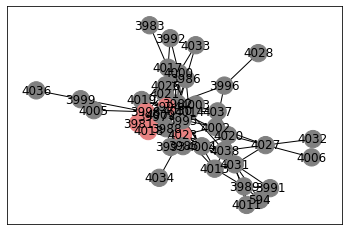

In [30]:
# Find and plot the largest cliques (from https://orbifold.net/default/community-detection-using-networkx/)
cliques = list(nx.find_cliques(G))
max_clique = max(cliques, key=len)
node_color = [(0.5, 0.5, 0.5) for v in G.nodes()]
for i, v in enumerate(G.nodes()):
  if v in max_clique:
    print(v)
    node_color[i] = (0.9, 0.5, 0.5)
nx.draw_networkx(G, node_color=node_color)

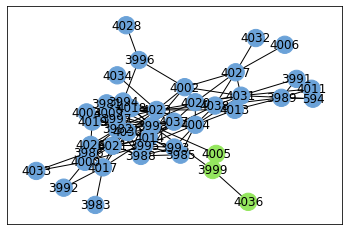

In [31]:
# Community detection (from https://orbifold.net/default/community-detection-using-networkx/)
def get_color(i, r_off=1, g_off=1, b_off=1):
  r0, g0, b0 = 0, 0, 0
  n = 16
  low, high = 0.1, 0.9
  span = high - low
  r = low + span * (((i + r_off) * 3) % n) / (n - 1)
  g = low + span * (((i + g_off) * 5) % n) / (n - 1)
  b = low + span * (((i + b_off) * 7) % n) / (n - 1)
  return (r, g, b)  
def set_node_community(G, communities):
  for c, v_c in enumerate(communities):
    for v in v_c:
      G.nodes[v]['community'] = c + 1

result = nx.community.girvan_newman(G)
communities = next(result)
set_node_community(G, communities)
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

nx.draw_networkx(G, node_color=node_color)

***Download the html file and submit to BeachBoard***<br>
<br>
1.   ***Download the lab11.ipynb file***
2.   ***Upload the lab11.ipynb file***
3.   ***Run the code below to generate a html file***
4.   ***Download the html file and submit to BeachBoard***

In [32]:
!jupyter nbconvert --to html IS470_lab11.ipynb

[NbConvertApp] Converting notebook IS470_lab11.ipynb to html
[NbConvertApp] Writing 506118 bytes to IS470_lab11.html
